# Visualizing Weights During Training

In [1]:
import platform; print("Platform", platform.platform())
import sys; print("Python", sys.version)
import torch; print("PyTorch", torch.__version__)
import torchvision; print("torchvision", torchvision.__version__)
import torchvision.transforms as transforms

Platform Linux-4.15.0-1060-aws-x86_64-with-debian-buster-sid
Python 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56) 
[GCC 7.2.0]
PyTorch 1.3.1
torchvision 0.4.2


This reference is based off of [an example](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) from the PyTorch website.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(
         mean=(0.5, 0.5, 0.5), 
         std=(0.5, 0.5, 0.5)
     )])

trainset = torchvision.datasets.CIFAR10(
    root='../data/external', 
    train=True,
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='../data/external', 
    train=False, 
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=32,
    shuffle=False, 
    num_workers=2
)

classes = (
    'plane', 
    'car', 
    'bird', 
    'cat',
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
)

Files already downloaded and verified
Files already downloaded and verified


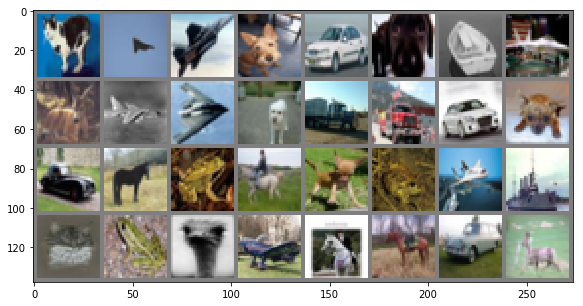

  cat plane plane   dog


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [5]:
def single_hist(axes_ij, x, title=None, ylab=None):
    x = np.reshape(x, -1)
    n, bins, patches = axes_ij.hist(
        x, 50, density=True, facecolor='g', alpha=.95, histtype='step')
    if ylab:
        axes_ij.set_ylabel(ylab)
    if title:
        axes_ij.set_title(title)
    axes_ij.set_xlim(-0.25, .25)

def single_row(axes, x_list, titles, ylab):
    for i in range(len(x_list)):
        if i > 0: ylab = None
        single_hist(axes[i], x_list[i], titles[i], ylab)

def get_numpy(x):
    return x.detach().cpu().numpy()

def get_numpy_wt(layer):
    return get_numpy(layer.weight)

def get_numpy_bias(layer):
    return get_numpy(layer.bias)

def get_wts_biases(neural_net):
    layers = [neural_net.fc1, neural_net.fc2, neural_net.fc3]
    return list(map(get_numpy_bias, layers)), list(map(get_numpy_wt, layers))

In [6]:
init_biases, init_weights = get_wts_biases(net)

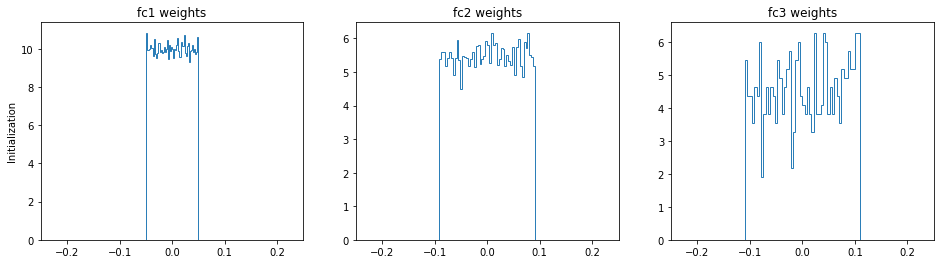

In [7]:
fig, axes = plt.subplots(1,3, figsize = (16,4))
single_row(axes, init_weights, ['fc1 weights', 'fc2 weights', 'fc3 weights'], 'Initialization')

## Training

In [8]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
def train(
    neural_net, 
    criterion, 
    optimizer,
    n_epochs, 
    train_dataloader, 
):
    for epoch in range(n_epochs):
        running_loss = 0.0
        steps = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            steps+=1
        print(f'Epoch: {epoch+1} | Steps: {steps+1} | Loss: {running_loss / steps:.2}')
    return net

## Train for 1 epoch

In [10]:
net = train(net, criterion, optimizer, 1, trainloader)
biases_1epoch, weights_1epoch = get_wts_biases(net)

Epoch: 1 | Steps: 1564.0 | Loss: 2.2


## Train for 10 epochs

In [11]:
net = train(net, criterion, optimizer, 9, trainloader)
biases_10epoch, weights_10epoch = get_wts_biases(net)

Epoch: 1 | Steps: 1564.0 | Loss: 1.7
Epoch: 2 | Steps: 1564.0 | Loss: 1.6
Epoch: 3 | Steps: 1564.0 | Loss: 1.4
Epoch: 4 | Steps: 1564.0 | Loss: 1.4
Epoch: 5 | Steps: 1564.0 | Loss: 1.3
Epoch: 6 | Steps: 1564.0 | Loss: 1.2
Epoch: 7 | Steps: 1564.0 | Loss: 1.2
Epoch: 8 | Steps: 1564.0 | Loss: 1.1
Epoch: 9 | Steps: 1564.0 | Loss: 1.1


## Train for 100 epochs

In [12]:
net = train(net, criterion, optimizer, 90, trainloader)
biases_100epoch, weights_100epoch = get_wts_biases(net)

Epoch: 1 | Steps: 1564.0 | Loss: 1.1
Epoch: 2 | Steps: 1564.0 | Loss: 1.0
Epoch: 3 | Steps: 1564.0 | Loss: 1.0
Epoch: 4 | Steps: 1564.0 | Loss: 0.98
Epoch: 5 | Steps: 1564.0 | Loss: 0.95
Epoch: 6 | Steps: 1564.0 | Loss: 0.93
Epoch: 7 | Steps: 1564.0 | Loss: 0.9
Epoch: 8 | Steps: 1564.0 | Loss: 0.88
Epoch: 9 | Steps: 1564.0 | Loss: 0.86
Epoch: 10 | Steps: 1564.0 | Loss: 0.84
Epoch: 11 | Steps: 1564.0 | Loss: 0.82
Epoch: 12 | Steps: 1564.0 | Loss: 0.8
Epoch: 13 | Steps: 1564.0 | Loss: 0.78
Epoch: 14 | Steps: 1564.0 | Loss: 0.76
Epoch: 15 | Steps: 1564.0 | Loss: 0.74
Epoch: 16 | Steps: 1564.0 | Loss: 0.72
Epoch: 17 | Steps: 1564.0 | Loss: 0.71
Epoch: 18 | Steps: 1564.0 | Loss: 0.69
Epoch: 19 | Steps: 1564.0 | Loss: 0.67
Epoch: 20 | Steps: 1564.0 | Loss: 0.66
Epoch: 21 | Steps: 1564.0 | Loss: 0.64
Epoch: 22 | Steps: 1564.0 | Loss: 0.62
Epoch: 23 | Steps: 1564.0 | Loss: 0.61
Epoch: 24 | Steps: 1564.0 | Loss: 0.59
Epoch: 25 | Steps: 1564.0 | Loss: 0.58
Epoch: 26 | Steps: 1564.0 | Loss: 0.56


## Visualizing the Weights

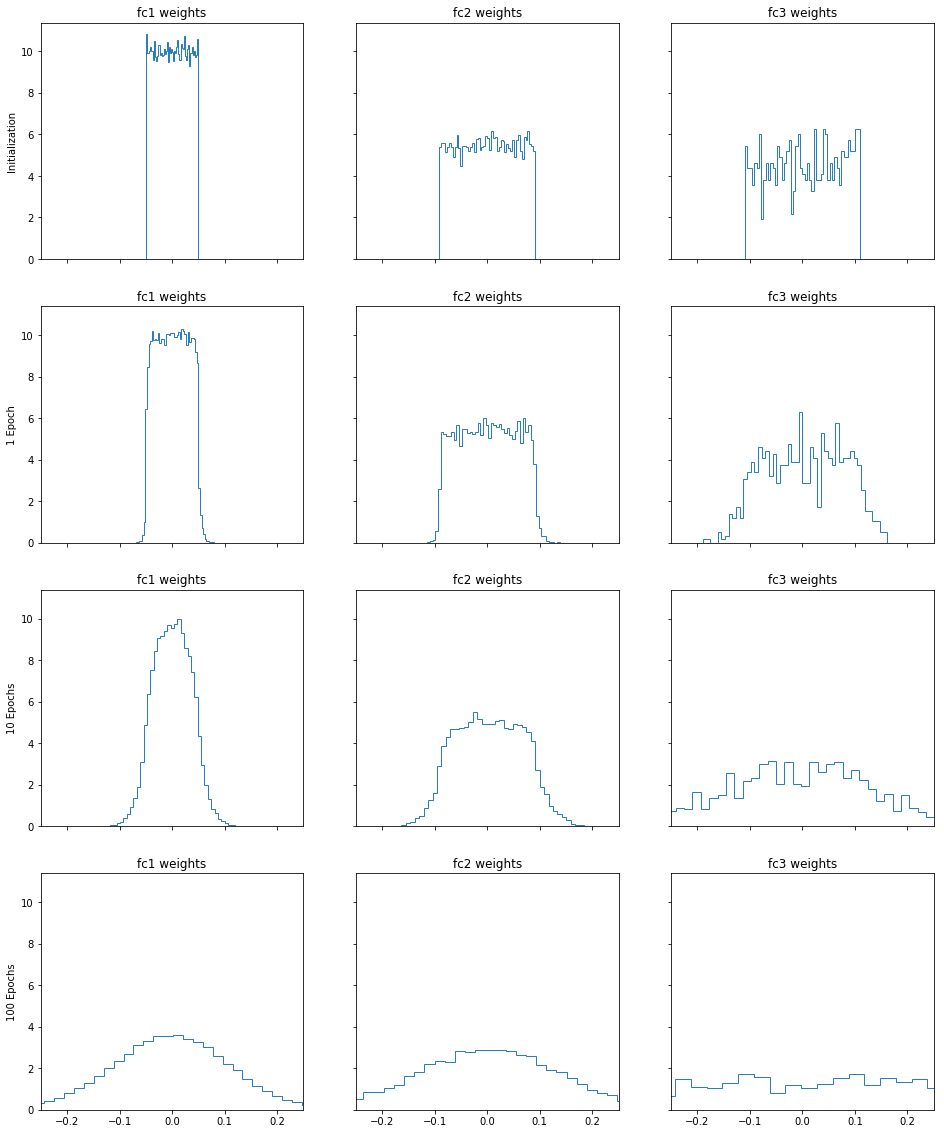

In [13]:
fig, axes = plt.subplots(4,3, figsize = (16,20), sharex=True, sharey=True)
single_row(axes[0,:], init_weights, ['fc1 weights', 'fc2 weights', 'fc3 weights'], 'Initialization')
single_row(axes[1,:], weights_1epoch, ['fc1 weights', 'fc2 weights', 'fc3 weights'], '1 Epoch')
single_row(axes[2,:], weights_10epoch, ['fc1 weights', 'fc2 weights', 'fc3 weights'], '10 Epochs')
single_row(axes[3,:], weights_100epoch, ['fc1 weights', 'fc2 weights', 'fc3 weights'], '100 Epochs')

## Visualizing the Biases

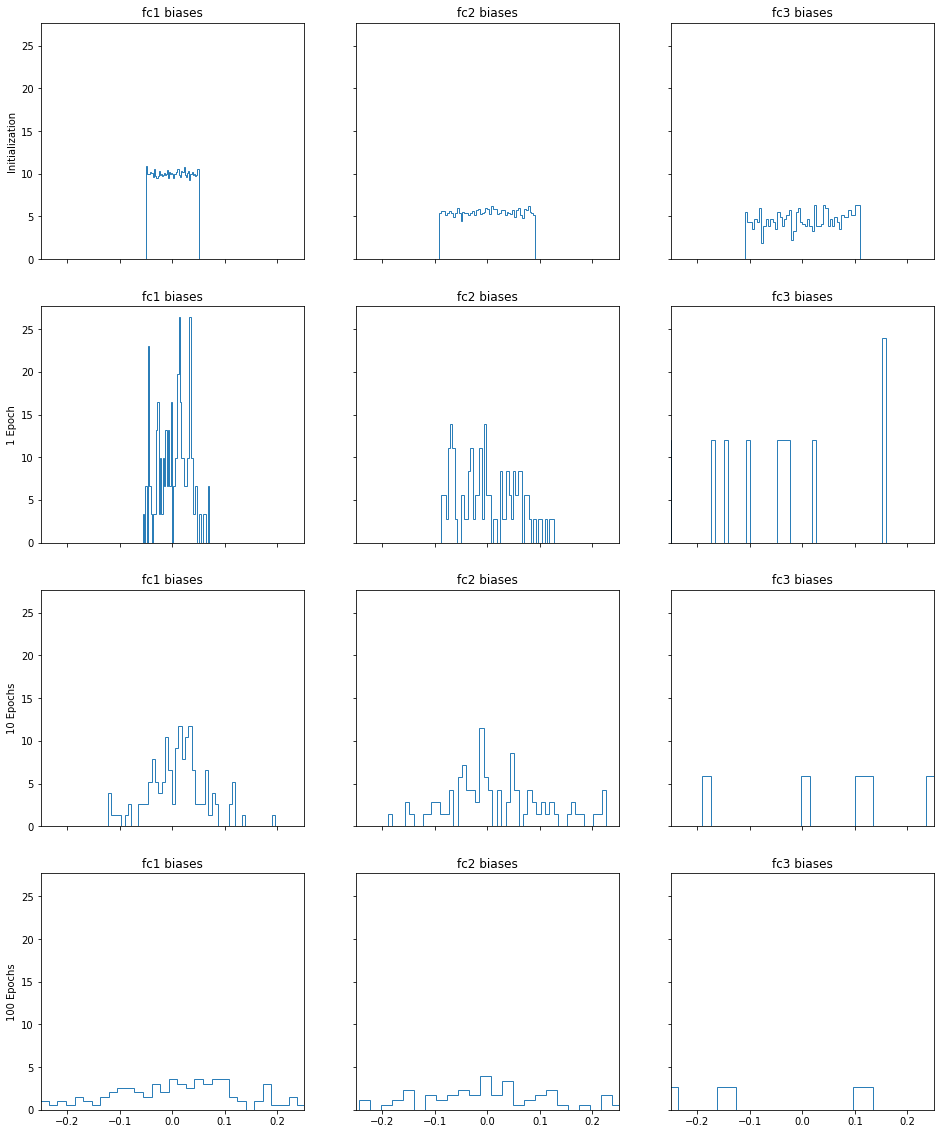

In [14]:
fig, axes = plt.subplots(4,3, figsize = (16,20), sharex=True, sharey=True)
single_row(axes[0,:], init_weights, ['fc1 biases', 'fc2 biases', 'fc3 biases'], 'Initialization')
single_row(axes[1,:], biases_1epoch, ['fc1 biases', 'fc2 biases', 'fc3 biases'], '1 Epoch')
single_row(axes[2,:], biases_10epoch, ['fc1 biases', 'fc2 biases', 'fc3 biases'], '10 Epochs')
single_row(axes[3,:], biases_100epoch, ['fc1 biases', 'fc2 biases', 'fc3 biases'], '100 Epochs')